## Setup & Definitions
Here we import the necessary libraries and define the classes and the functions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from itertools import cycle
import itertools

In [ ]:
# To save the outputs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_results_path = '/content/drive/MyDrive/interleaved_training_results'

In [ ]:
# A single block for a CNN with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Two convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample the input feature map to match dimensions if necessary
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = None

    # Forward pass of the residual block
    def forward(self, x):
        identity = x # Save the input value for the skip connection

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Apply downsampling if required
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity

        return F.relu(out)

# Architecture for 32x32 RGB input (CIFAR10 and SVHN Dataset)
class MultiHeadCNN(nn.Module):
    def __init__(self):
        super(MultiHeadCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.resblock1 = ResidualBlock(32, 64, stride=2)
        self.resblock2 = ResidualBlock(64, 128, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.head1 = nn.Linear(256, 5)  # First head (classes 0-4)
        self.head2 = nn.Linear(256, 5)  # Second head (classes 5-9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        out1 = self.head1(x)
        out2 = self.head2(x)
        return out1, out2

# Architecture for 96x96 RGB input (STL-10 Dataset)
class MultiHeadCNN_96(nn.Module):
    def __init__(self):
        super(MultiHeadCNN_96, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.resblock1 = ResidualBlock(32, 64, stride=2)
        self.resblock2 = ResidualBlock(64, 128, stride=2)
        self.fc1 = nn.Linear(128 * 24 * 24, 256)
        self.head1 = nn.Linear(256, 5)  # First head (classes 0-4)
        self.head2 = nn.Linear(256, 5)  # Second head (classes 5-9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = x.view(-1, 128 * 24 * 24)
        x = F.relu(self.fc1(x))
        out1 = self.head1(x)
        out2 = self.head2(x)
        return out1, out2

# Architecture for  28x28 grayscale input (MNIST/FashionMNIST datasets)
class MultiHeadCNN_MNIST(nn.Module):
    def __init__(self):
        super(MultiHeadCNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 64)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.head1 = nn.Linear(256, 5)  # First head (classes 0-4)
        self.head2 = nn.Linear(256, 5)  # Second head (classes 5-9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # Reduce to 14x14
        x = self.resblock1(x)
        x = F.max_pool2d(x, 2)  # Reduce to 7x7
        x = self.resblock2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        out1 = self.head1(x)
        out2 = self.head2(x)
        return out1, out2




def train(model, device, train_loader, optimizer, active_head, val_loader1, val_loader2):
    model.train()
    batch_losses = []
    batch_accuracies = []
    val_accuracies_1 = []
    val_accuracies_2 = []

    # Create an iterable that cycles through the validation data
    # We evaluate a batch obtained from this here as validation through each step
    val_iter1 = cycle(val_loader1)
    val_iter2 = cycle(val_loader2)

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training Progress")):
        data, target = data.to(device), target.to(device)

        # Perform forward pass
        output1, output2 = model(data)
        if active_head == "head1":
            output = output1
        else:
            output = output2
            target -= 5  # Adjust labels for the second head

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = 100. * correct / target.size(0)
        batch_accuracies.append(accuracy)

        # Compute loss and backpropagate
        loss = torch.nn.functional.cross_entropy(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())


        model.eval()
        # Head 1
        val_data1, val_target1 = next(val_iter1)
        val_data1, val_target1 = val_data1.to(device), val_target1.to(device)
        val_output1, _ = model(val_data1)
        val_pred1 = val_output1.argmax(dim=1, keepdim=True)
        val_correct1 = val_pred1.eq(val_target1.view_as(val_pred1)).sum().item()
        val_total1 = val_target1.size(0)
        val_accuracy1 = 100. * val_correct1 / val_total1
        val_accuracies_1.append(val_accuracy1)

        # Head 2
        val_data2, val_target2 = next(val_iter2)
        val_data2, val_target2 = val_data2.to(device), val_target2.to(device)
        _, val_output2 = model(val_data2)
        val_target2 -= 5  # Adjust labels for the second head
        val_pred2 = val_output2.argmax(dim=1, keepdim=True)
        val_correct2 = val_pred2.eq(val_target2.view_as(val_pred2)).sum().item()
        val_total2 = val_target2.size(0)
        val_accuracy2 = 100. * val_correct2 / val_total2
        val_accuracies_2.append(val_accuracy2)

        model.train()

    return batch_losses, batch_accuracies, val_accuracies_1, val_accuracies_2



# Iterating through epochs
def training_loop(model, optimizer, run_length, total_epochs, experiment_name):
  for epoch in range(1, total_epochs + 1):
    if ((epoch-1) % (2 * run_length)) < run_length:
        print(f'On head 1, epoch {epoch}...')
        losses, accuracies, val_accuracies_1, val_accuracies_2 = train(model, device, loader_head1, optimizer, "head1", val_loader1 = loader_head1_test, val_loader2 = loader_head2_test)
        head = 1
        color = 'green'
    else:
        print(f'On head 2, epoch {epoch}...')
        losses, accuracies, val_accuracies_1, val_accuracies_2 = train(model, device, loader_head2, optimizer, "head2", val_loader1 = loader_head1_test, val_loader2 = loader_head2_test)
        head = 2
        color = 'orange'

    all_losses.extend(losses)
    all_accuracies.extend(accuracies)
    all_accuracies_val1.extend(val_accuracies_1)
    all_accuracies_val2.extend(val_accuracies_2)
    batch_heads.extend([head] * len(losses))
    colors.extend([color] * len(losses))

  data = {
      'all_losses': all_losses,
      'all_accuracies': all_accuracies,
      'all_accuracies_val1': all_accuracies_val1,
      'all_accuracies_val2': all_accuracies_val2,
      'batch_heads': batch_heads,
      'colors': colors
  }

  # Define the file path
  file_path = drive_results_path + f'/{experiment_name}.json'

  # Write the dictionary to a file as JSON
  with open(file_path, 'w') as file:
      json.dump(data, file)

def train_iid(model, device, data, target, optimizer, active_head, val_loader1, val_loader2):
    model.train()
    batch_losses = []
    batch_accuracies = []
    val_accuracies_1 = []
    val_accuracies_2 = []

    # Create an iterable that cycles through the validation data
    # We evaluate a batch obtained from this here as validation through each step
    val_iter1 = cycle(val_loader1)
    val_iter2 = cycle(val_loader2)
    data, target = data.to(device), target.to(device)


    # Perform forward pass
    output1, output2 = model(data)
    if active_head == "head1":
        output = output1
    else:
        output = output2
        target -= 5  # Adjust labels for the second head

    # Calculate accuracy
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / target.size(0)
    batch_accuracies.append(accuracy)

    # Compute loss and backpropagate
    loss = torch.nn.functional.cross_entropy(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_losses.append(loss.item())


    model.eval()
    # Head 1
    val_data1, val_target1 = next(val_iter1)
    val_data1, val_target1 = val_data1.to(device), val_target1.to(device)
    val_output1, _ = model(val_data1)
    val_pred1 = val_output1.argmax(dim=1, keepdim=True)
    val_correct1 = val_pred1.eq(val_target1.view_as(val_pred1)).sum().item()
    val_total1 = val_target1.size(0)
    val_accuracy1 = 100. * val_correct1 / val_total1
    val_accuracies_1.append(val_accuracy1)

    # Head 2
    val_data2, val_target2 = next(val_iter2)
    val_data2, val_target2 = val_data2.to(device), val_target2.to(device)
    _, val_output2 = model(val_data2)
    val_target2 -= 5  # Adjust labels for the second head
    val_pred2 = val_output2.argmax(dim=1, keepdim=True)
    val_correct2 = val_pred2.eq(val_target2.view_as(val_pred2)).sum().item()
    val_total2 = val_target2.size(0)
    val_accuracy2 = 100. * val_correct2 / val_total2
    val_accuracies_2.append(val_accuracy2)

    model.train()

    return batch_losses, batch_accuracies, val_accuracies_1, val_accuracies_2

# Iterating through epochs for iid setting
def training_loop_iid(model, optimizer, run_length, total_epochs, experiment_name):
  for epoch in range(1, total_epochs + 1):
      print(f"Epoch {epoch}...")
      # Create iterators for both loaders
      iter_head1 = iter(loader_head1)
      iter_head2 = iter(loader_head2)

      # Cycle through both iterators
      for (data1, target1), (data2, target2) in itertools.zip_longest(iter_head1, iter_head2, fillvalue=(None, None)):
          if data1 is not None:
            losses, accuracies, val_accuracies_1, val_accuracies_2 = train_iid(model, device, data1, target1, optimizer, "head1", val_loader1 = loader_head1_test, val_loader2 = loader_head2_test)
            head = 1
            color = 'green'
            all_losses.extend(losses)
            all_accuracies.extend(accuracies)
            all_accuracies_val1.extend(val_accuracies_1)
            all_accuracies_val2.extend(val_accuracies_2)
            batch_heads.extend([head] * len(losses))
            colors.extend([color] * len(losses))
          if data2 is not None:
            losses, accuracies, val_accuracies_1, val_accuracies_2 = train_iid(model, device, data2, target2, optimizer, "head2", val_loader1 = loader_head1_test, val_loader2 = loader_head2_test)
            head = 2
            color = 'orange'
            all_losses.extend(losses)
            all_accuracies.extend(accuracies)
            all_accuracies_val1.extend(val_accuracies_1)
            all_accuracies_val2.extend(val_accuracies_2)
            batch_heads.extend([head] * len(losses))
            colors.extend([color] * len(losses))


  data = {
      'all_losses': all_losses,
      'all_accuracies': all_accuracies,
      'all_accuracies_val1': all_accuracies_val1,
      'all_accuracies_val2': all_accuracies_val2,
      'batch_heads': batch_heads,
      'colors': colors
  }

  # Define the file path
  file_path = drive_results_path + f'/{experiment_name}.json'

  # Write the dictionary to a file as JSON
  with open(file_path, 'w') as file:
      json.dump(data, file)


# Function to count the number of parameters in a model
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Dividing a Single Dataset

## 1) CIFAR5 + CIFAR5 (paper)  

In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets
train_dataset = datasets.CIFAR10('./CIFAR10', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                ]))

# Prepare the CIFAR10 test dataset
test_dataset = datasets.CIFAR10('./CIFAR10', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                ]))

# Separate datasets for each head
indices_head1 = [i for i, (_, target) in enumerate(train_dataset) if target < 5]
indices_head2 = [i for i, (_, target) in enumerate(train_dataset) if target >= 5]

indices_head1_test = [i for i, (_, target) in enumerate(test_dataset) if target < 5]
indices_head2_test = [i for i, (_, target) in enumerate(test_dataset) if target >= 5]


# The first dataset includes the classes for the first head, and the second dataset for the second head
dataset_head1 = Subset(train_dataset, indices_head1)
dataset_head2 = Subset(train_dataset, indices_head2)

dataset_head1_test = Subset(test_dataset, indices_head1_test)
dataset_head2_test = Subset(test_dataset, indices_head2_test)

bs = 512
loader_head1 = DataLoader(dataset_head1, batch_size=bs, shuffle=True)
loader_head2 = DataLoader(dataset_head2, batch_size=bs, shuffle=True)

loader_head1_test = DataLoader(dataset_head1_test, batch_size=bs, shuffle=True)
loader_head2_test = DataLoader(dataset_head2_test, batch_size=bs, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define how many epochs to run for each head before switching
run_lengths = [3,6,15]
total_epochs = 60*2  # Total number of epochs to train

for run_length in run_lengths:
  print(f'***Running for run_length={run_length}***')
  all_losses = []
  all_accuracies = []
  all_accuracies_val1 = [] # Validation output for head 1
  all_accuracies_val2 = [] # Validation output for head 2
  batch_heads = []
  colors = []
  model = MultiHeadCNN().to(device)
  #optimizer = Adam(model.parameters())
  optimizer_name = 'SGD'
  optimizer = SGD(model.parameters(),lr=0.002, momentum=0.9)
  experiment_name = f'cifar5_cifar5/rl{run_length}_bs{bs}_epochs{total_epochs//2}_{optimizer_name}_lr{optimizer.param_groups[0]["lr"]}_momentum{optimizer.param_groups[0]["momentum"]}'
  if run_length == 0: # Reserve 0 for iid setting
    training_loop_iid(model, optimizer, run_length, total_epochs//2, experiment_name)
  else:
    training_loop(model, optimizer, run_length, total_epochs, experiment_name)


***Running for run_length=3***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 4...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 5...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 6...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 19...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 20...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 21...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.28it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.97it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.33it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 40...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 41...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 42...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 55...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 56...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 57...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.68it/s]


On head 2, epoch 64...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 65...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 66...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 67...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 68...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]


On head 1, epoch 69...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 70...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 71...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 72...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 76...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 77...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 78...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 79...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 80...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 81...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 85...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 86...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 87...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 88...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 89...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 90...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 91...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 92...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.51it/s]


On head 1, epoch 93...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 2, epoch 94...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]


On head 2, epoch 95...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 2, epoch 96...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]


On head 1, epoch 97...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 98...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 99...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]


On head 2, epoch 100...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 101...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]


On head 2, epoch 102...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]


On head 1, epoch 103...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.51it/s]


On head 1, epoch 104...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 105...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 106...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 107...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 108...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 109...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 110...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 111...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 112...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 113...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 114...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 115...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 116...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 117...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 118...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 119...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 120...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


***Running for run_length=6***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 7...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 8...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 9...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 16...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 17...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 18...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 43...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 44...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 45...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 52...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 53...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 54...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 64...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 65...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 66...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 67...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 68...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 69...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 70...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 71...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 72...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 76...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 77...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 78...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 79...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 80...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 81...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.51it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 1, epoch 85...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 86...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 87...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 88...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 89...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 90...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 91...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 92...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 2, epoch 93...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 94...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 95...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 96...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]


On head 1, epoch 97...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 98...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 99...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 100...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 101...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 102...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 103...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 104...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 105...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 2, epoch 106...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


On head 2, epoch 107...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 2, epoch 108...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 109...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]


On head 1, epoch 110...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 111...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 112...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 113...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 114...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.51it/s]


On head 2, epoch 115...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 2, epoch 116...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 2, epoch 117...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]


On head 2, epoch 118...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


On head 2, epoch 119...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 120...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


***Running for run_length=15***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.69it/s]


On head 1, epoch 11...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 12...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 25...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 26...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 27...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 34...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 35...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 36...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 49...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 2, epoch 50...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 64...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 65...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 66...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 67...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 68...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 69...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 70...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 71...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 72...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 76...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 77...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 78...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 79...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 80...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.66it/s]


On head 2, epoch 81...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 85...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 86...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 2, epoch 87...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 88...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 89...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 2, epoch 90...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


On head 1, epoch 91...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 92...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 1, epoch 93...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 94...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 95...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.52it/s]


On head 1, epoch 96...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


On head 1, epoch 97...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 98...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


On head 1, epoch 99...


Training Progress: 100%|██████████| 49/49 [00:14<00:00,  3.44it/s]


On head 1, epoch 100...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 1, epoch 101...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


On head 1, epoch 102...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


On head 1, epoch 103...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 1, epoch 104...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 1, epoch 105...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 106...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 107...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 108...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


On head 2, epoch 109...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.70it/s]


On head 2, epoch 110...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


On head 2, epoch 111...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.68it/s]


On head 2, epoch 112...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 113...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


On head 2, epoch 114...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


On head 2, epoch 115...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 116...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


On head 2, epoch 117...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 118...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


On head 2, epoch 119...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


On head 2, epoch 120...


Training Progress: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


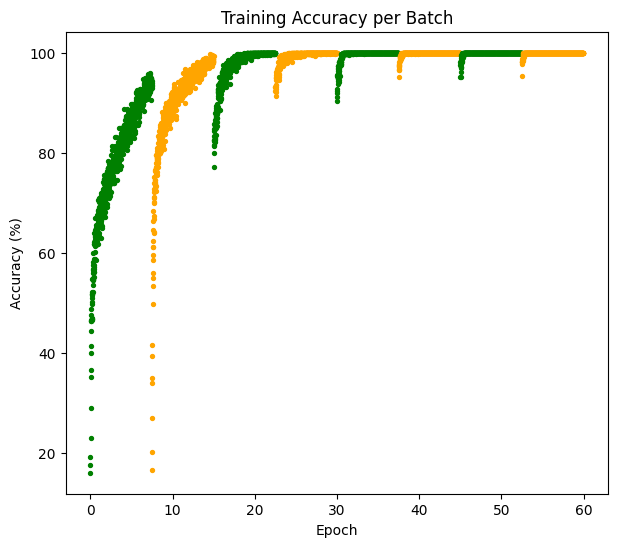

In [ ]:
plt.figure(figsize=(7, 6))
for i, acc in enumerate(all_accuracies):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/98, acc, color=colors[i], s=8)  # 's' controls the size of the scatter points
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

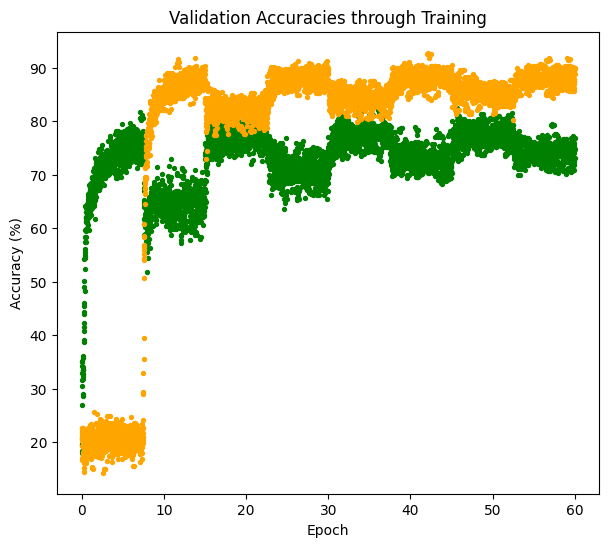

In [ ]:
plt.figure(figsize=(7, 6))  # Adjusted figure size since we're plotting one chart
for i, acc in enumerate(all_accuracies_val1):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/98, acc, color='green', s=8)  # 's' controls the size of the scatter points
for i, acc in enumerate(all_accuracies_val2):
    plt.scatter(i/98, acc, color='orange', s=8)  # 's' controls the size of the scatter points
plt.title('Validation Accuracies through Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Example access to the data
file_path = '/content/drive/MyDrive/interleaved_training_results/cifar5_cifar5/rl4_bs512_SGD_lr0.002_mmntm0.9.json'
# Read the JSON file back into a dictionary
with open(file_path, 'r') as file:
    loaded_data = json.load(file)
loaded_all_losses = loaded_data['all_losses']
loaded_all_accuracies = loaded_data['all_accuracies']
loaded_all_accuracies_val1 = loaded_data['all_accuracies_val1']
loaded_all_accuracies_val2 = loaded_data['all_accuracies_val2']
loaded_batch_heads = loaded_data['batch_heads']
loaded_colors = loaded_data['colors']

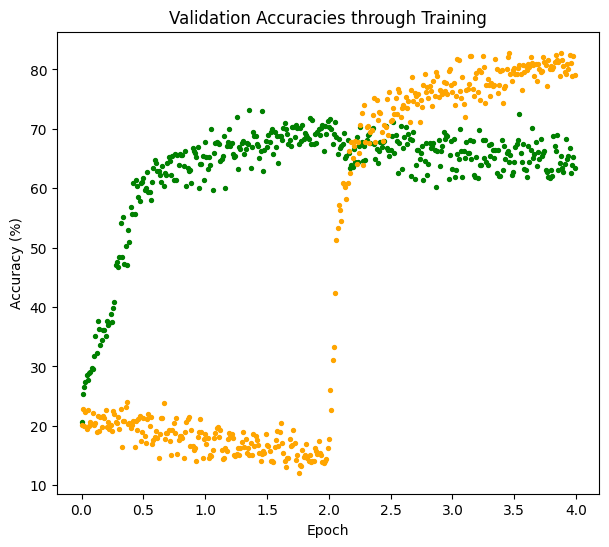

In [ ]:
# Observe whether values are saved and loaded properly
plt.figure(figsize=(7, 6))  # Adjusted figure size since we're plotting one chart
for i, acc in enumerate(loaded_all_accuracies_val1):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/98, acc, color='green', s=8)  # 's' controls the size of the scatter points
for i, acc in enumerate(loaded_all_accuracies_val2):
    plt.scatter(i/98, acc, color='orange', s=8)  # 's' controls the size of the scatter points
plt.title('Validation Accuracies through Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

## 2) STL5 + STL5 (alternative)


In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the STL10 dataset
train_dataset = datasets.STL10('./STL10', split='train', download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  # Normalize using mean and std of STL10 dataset
                                  transforms.Normalize(mean=[0.43, 0.42, 0.39], std=[0.27, 0.26, 0.27])
                              ]))
test_dataset = datasets.STL10('./STL10', split='test', download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  # Normalize using mean and std of STL10 dataset
                                  transforms.Normalize(mean=[0.43, 0.42, 0.39], std=[0.27, 0.26, 0.27])
                              ]))


# Separate datasets for each head
indices_head1 = [i for i, (_, target) in enumerate(train_dataset) if target < 5]
indices_head2 = [i for i, (_, target) in enumerate(train_dataset) if target >= 5]

indices_head1_test = [i for i, (_, target) in enumerate(test_dataset) if target < 5]
indices_head2_test = [i for i, (_, target) in enumerate(test_dataset) if target >= 5]


# The first dataset includes the classes for the first head, and the second dataset for the second head
dataset_head1 = Subset(train_dataset, indices_head1)
dataset_head2 = Subset(train_dataset, indices_head2)

dataset_head1_test = Subset(test_dataset, indices_head1_test)
dataset_head2_test = Subset(test_dataset, indices_head2_test)

bs = 64
loader_head1 = DataLoader(dataset_head1, batch_size=bs, shuffle=True)
loader_head2 = DataLoader(dataset_head2, batch_size=bs, shuffle=True)

val_bs = 256
loader_head1_test = DataLoader(dataset_head1_test, batch_size=val_bs, shuffle=True)
loader_head2_test = DataLoader(dataset_head2_test, batch_size=val_bs, shuffle=True)

100%|██████████| 2640397119/2640397119 [00:57<00:00, 46194643.63it/s]


Extracting ./STL10/stl10_binary.tar.gz to ./STL10
Files already downloaded and verified


In [ ]:
# Define how many epochs to run for each head before switching
run_lengths = [6,15]
total_epochs = 30*2  # Total number of epochs to train

for run_length in run_lengths:
  print(f'***Running for run_length={run_length}***')
  all_losses = []
  all_accuracies = []
  all_accuracies_val1 = [] # Validation output for head 1
  all_accuracies_val2 = [] # Validation output for head 2
  batch_heads = []
  colors = []
  model = MultiHeadCNN_96().to(device)
  #optimizer = Adam(model.parameters())
  optimizer_name = 'SGD'
  optimizer = SGD(model.parameters(),lr=0.002, momentum=0.0)
  experiment_name = f'stl5_stl5/rl{run_length}_bs{bs}_epochs{total_epochs//2}_{optimizer_name}_lr{optimizer.param_groups[0]["lr"]}_momentum{optimizer.param_groups[0]["momentum"]}'
  if run_length == 0: # Reserve 0 for iid setting
    training_loop_iid(model, optimizer, run_length, total_epochs//2, experiment_name)
  else:
    training_loop(model, optimizer, run_length, total_epochs, experiment_name)

***Running for run_length=6***
On head 1, epoch 1...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


On head 2, epoch 7...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


On head 2, epoch 8...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


On head 2, epoch 9...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 16...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 17...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 18...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 43...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 44...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 2, epoch 45...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 52...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 53...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 1, epoch 54...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


***Running for run_length=15***
On head 1, epoch 1...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 11...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 1, epoch 12...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 25...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 26...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 2, epoch 27...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 34...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


On head 1, epoch 35...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 36...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 49...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 50...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


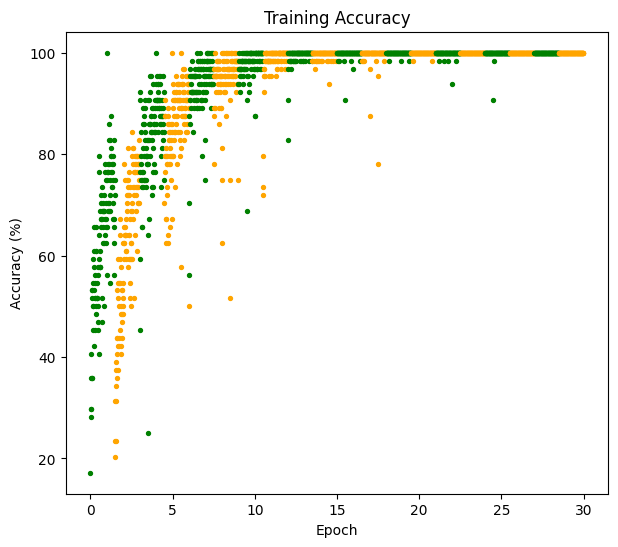

In [ ]:
plt.figure(figsize=(7, 6))
for i, acc in enumerate(all_accuracies):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/80, acc, color=colors[i], s=8)  # 's' controls the size of the scatter points
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

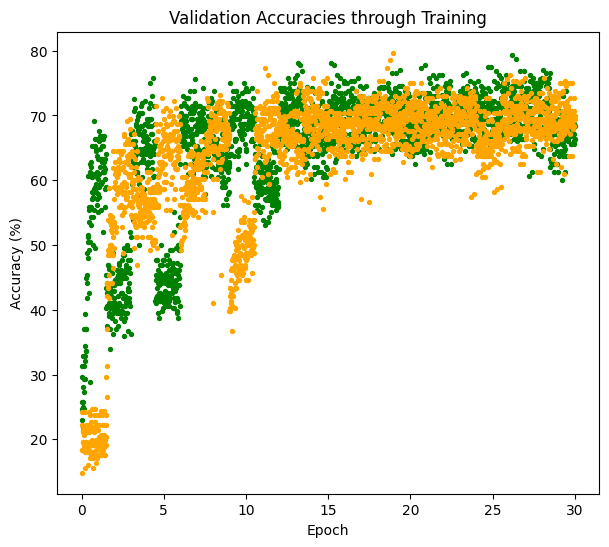

In [ ]:
plt.figure(figsize=(7, 6))  # Adjusted figure size since we're plotting one chart
for i, acc in enumerate(all_accuracies_val1):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/80, acc, color='green', s=8)  # 's' controls the size of the scatter points
for i, acc in enumerate(all_accuracies_val2):
    plt.scatter(i/80, acc, color='orange', s=8)  # 's' controls the size of the scatter points
plt.title('Validation Accuracies through Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Access the data
#loaded_all_losses = loaded_data['all_losses']
#loaded_all_accuracies = loaded_data['all_accuracies']
#loaded_batch_heads = loaded_data['batch_heads']
#loaded_colors = loaded_data['colors']

## 3) MNIST5 + MNIST5 (alternative)

In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets
train_dataset = datasets.MNIST('./MNIST', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

test_dataset = datasets.MNIST('./MNIST', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))


# Separate datasets for each head
indices_head1 = [i for i, (_, target) in enumerate(train_dataset) if target < 5]
indices_head2 = [i for i, (_, target) in enumerate(train_dataset) if target >= 5]

indices_head1_test = [i for i, (_, target) in enumerate(test_dataset) if target < 5]
indices_head2_test = [i for i, (_, target) in enumerate(test_dataset) if target >= 5]


# The first dataset includes the classes for the first head, and the second dataset for the second head
dataset_head1 = Subset(train_dataset, indices_head1)
dataset_head2 = Subset(train_dataset, indices_head2)

dataset_head1_test = Subset(test_dataset, indices_head1_test)
dataset_head2_test = Subset(test_dataset, indices_head2_test)

bs = 512
loader_head1 = DataLoader(dataset_head1, batch_size=bs, shuffle=True)
loader_head2 = DataLoader(dataset_head2, batch_size=bs, shuffle=True)

val_bs = 512
loader_head1_test = DataLoader(dataset_head1_test, batch_size=val_bs, shuffle=True)
loader_head2_test = DataLoader(dataset_head2_test, batch_size=val_bs, shuffle=True)

In [ ]:
# Define how many epochs to run for each head before switching
run_lengths = [3,6,15]
total_epochs = 30*2  # Total number of epochs to train

for run_length in run_lengths:
  print(f'***Running for run_length={run_length}***')
  all_losses = []
  all_accuracies = []
  all_accuracies_val1 = [] # Validation output for head 1
  all_accuracies_val2 = [] # Validation output for head 2
  batch_heads = []
  colors = []
  model = MultiHeadCNN_MNIST().to(device)
  #optimizer = Adam(model.parameters())
  optimizer_name = 'SGD'
  optimizer = SGD(model.parameters(),lr=0.002, momentum=0.0)
  experiment_name = f'mnist5_mnist5/rl{run_length}_bs{bs}_epochs{total_epochs//2}_{optimizer_name}_lr{optimizer.param_groups[0]["lr"]}_momentum{optimizer.param_groups[0]["momentum"]}'
  if run_length == 0: # Reserve 0 for iid setting
    training_loop_iid(model, optimizer, run_length, total_epochs//2, experiment_name)
  else:
    training_loop(model, optimizer, run_length, total_epochs, experiment_name)

***Running for run_length=3***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


On head 2, epoch 4...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.46it/s]


On head 2, epoch 5...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]


On head 2, epoch 6...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.69it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.55it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 1, epoch 19...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 20...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


On head 1, epoch 21...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.70it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 2, epoch 40...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.46it/s]


On head 2, epoch 41...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.39it/s]


On head 2, epoch 42...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


On head 1, epoch 55...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.67it/s]


On head 1, epoch 56...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


On head 1, epoch 57...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.60it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]


***Running for run_length=6***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.66it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


On head 2, epoch 7...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 8...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 9...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.55it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.58it/s]


On head 1, epoch 16...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


On head 1, epoch 17...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 18...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.60it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.61it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.62it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 60/60 [00:12<00:00,  4.63it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.55it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.43it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


On head 2, epoch 43...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 44...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]


On head 2, epoch 45...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 52...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 53...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 54...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.44it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.63it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.55it/s]


***Running for run_length=15***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


On head 1, epoch 11...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.55it/s]


On head 1, epoch 12...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.46it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.54it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.49it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.46it/s]


On head 2, epoch 25...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.45it/s]


On head 2, epoch 26...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 27...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.67it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.61it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 60/60 [00:14<00:00,  4.05it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 60/60 [00:18<00:00,  3.32it/s]


On head 1, epoch 34...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.54it/s]


On head 1, epoch 35...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.31it/s]


On head 1, epoch 36...


Training Progress: 100%|██████████| 60/60 [00:16<00:00,  3.64it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:14<00:00,  4.11it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:15<00:00,  3.77it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 60/60 [00:15<00:00,  3.81it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.33it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.65it/s]


On head 2, epoch 49...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.45it/s]


On head 2, epoch 50...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.59it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.31it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.46it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 58/58 [00:13<00:00,  4.44it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.51it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


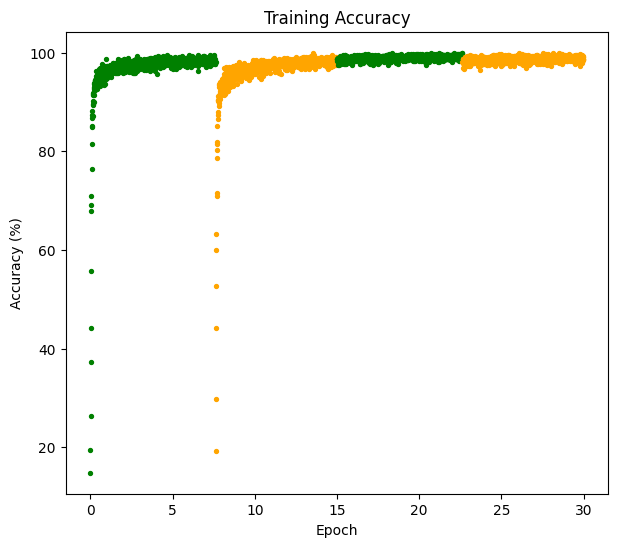

In [ ]:
plt.figure(figsize=(7, 6))
for i, acc in enumerate(all_accuracies):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/118, acc, color=colors[i], s=8)  # 's' controls the size of the scatter points
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Two Different Datasets


## 4) CIFAR5 + SVHN5


In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets
train_dataset1 = datasets.CIFAR10('./CIFAR10', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                ]))

train_dataset2 = datasets.SVHN('./SVHN', split='train', download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])
                             ]))

test_dataset1 = datasets.CIFAR10('./CIFAR10', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                ]))

test_dataset2 = datasets.SVHN('./SVHN', split='test', download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])
                             ]))


# Separate datasets for each head
indices_head1 = [i for i, (_, target) in enumerate(train_dataset1) if target < 5]
indices_head2 = [i for i, (_, target) in enumerate(train_dataset2) if target >= 5]

indices_head1_test = [i for i, (_, target) in enumerate(test_dataset1) if target < 5]
indices_head2_test = [i for i, (_, target) in enumerate(test_dataset2) if target >= 5]


# The first dataset includes the classes for the first head, and the second dataset for the second head
dataset_head1 = Subset(train_dataset1, indices_head1)
dataset_head2 = Subset(train_dataset2, indices_head2)

dataset_head1_test = Subset(test_dataset1, indices_head1_test)
dataset_head2_test = Subset(test_dataset2, indices_head2_test)

bs = 512
loader_head1 = DataLoader(dataset_head1, batch_size=bs, shuffle=True)
loader_head2 = DataLoader(dataset_head2, batch_size=bs, shuffle=True)

val_bs = 512
loader_head1_test = DataLoader(dataset_head1_test, batch_size=val_bs, shuffle=True)
loader_head2_test = DataLoader(dataset_head2_test, batch_size=val_bs, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 44882134.70it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


100%|██████████| 182040794/182040794 [00:14<00:00, 12922704.53it/s]


Files already downloaded and verified


100%|██████████| 64275384/64275384 [00:05<00:00, 10821241.57it/s]


In [ ]:
# Define how many epochs to run for each head before switching
run_lengths = [3,6,15]
total_epochs = 45*2  # Total number of epochs to train

for run_length in run_lengths:
  print(f'***Running for run_length={run_length}***')
  all_losses = []
  all_accuracies = []
  all_accuracies_val1 = [] # Validation output for head 1
  all_accuracies_val2 = [] # Validation output for head 2
  batch_heads = []
  colors = []
  model = MultiHeadCNN().to(device)
  #optimizer = Adam(model.parameters())
  optimizer_name = 'SGD'
  optimizer = SGD(model.parameters(),lr=0.002, momentum=0.0)
  experiment_name = f'cifar5_svhn5/rl{run_length}_bs{bs}_epochs{total_epochs//2}_{optimizer_name}_lr{optimizer.param_groups[0]["lr"]}_momentum{optimizer.param_groups[0]["momentum"]}'
  if run_length == 0: # Reserve 0 for iid setting
    training_loop_iid(model, optimizer, run_length, total_epochs//2, experiment_name)
  else:
    training_loop(model, optimizer, run_length, total_epochs, experiment_name)

***Running for run_length=3***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:17<00:00,  2.75it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


On head 2, epoch 4...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 5...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.04it/s]


On head 2, epoch 6...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.20it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.02it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


On head 1, epoch 19...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 20...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 21...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 2, epoch 40...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


On head 2, epoch 41...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 42...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.00it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 1, epoch 55...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


On head 1, epoch 56...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.06it/s]


On head 1, epoch 57...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 2, epoch 64...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


On head 2, epoch 65...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


On head 2, epoch 66...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 1, epoch 67...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 68...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 69...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 2, epoch 70...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


On head 2, epoch 71...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 72...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 2, epoch 76...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 2, epoch 77...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


On head 2, epoch 78...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 1, epoch 79...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 80...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


On head 1, epoch 81...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 55/55 [00:16<00:00,  3.25it/s]


On head 1, epoch 85...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


On head 1, epoch 86...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 87...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 2, epoch 88...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


On head 2, epoch 89...


Training Progress: 100%|██████████| 55/55 [00:16<00:00,  3.26it/s]


On head 2, epoch 90...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


***Running for run_length=6***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.96it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 2, epoch 7...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.11it/s]


On head 2, epoch 8...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


On head 2, epoch 9...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.02it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 1, epoch 16...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.98it/s]


On head 1, epoch 17...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 18...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.02it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.04it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.98it/s]


On head 2, epoch 43...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 44...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


On head 2, epoch 45...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


On head 1, epoch 52...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 1, epoch 53...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 54...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.02it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.12it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 55/55 [00:16<00:00,  3.24it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.97it/s]


On head 1, epoch 64...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 65...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 66...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 2, epoch 67...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 68...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.04it/s]


On head 2, epoch 69...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 70...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 71...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.06it/s]


On head 2, epoch 72...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 76...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.97it/s]


On head 1, epoch 77...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


On head 1, epoch 78...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 2, epoch 79...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 80...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


On head 2, epoch 81...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  2.99it/s]


On head 1, epoch 85...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 86...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 87...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 88...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


On head 1, epoch 89...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


On head 1, epoch 90...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


***Running for run_length=15***
On head 1, epoch 1...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.06it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 1, epoch 11...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 12...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.16it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.08it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


On head 2, epoch 25...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 26...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 27...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.07it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 1, epoch 34...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 35...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


On head 1, epoch 36...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.98it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.02it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 49...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.20it/s]


On head 2, epoch 50...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.01it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.23it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.19it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  2.99it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.22it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.15it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 1, epoch 61...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 62...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 63...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.14it/s]


On head 1, epoch 64...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 65...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


On head 1, epoch 66...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


On head 1, epoch 67...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 68...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.15it/s]


On head 1, epoch 69...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


On head 1, epoch 70...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.07it/s]


On head 1, epoch 71...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


On head 1, epoch 72...


Training Progress: 100%|██████████| 49/49 [00:16<00:00,  2.95it/s]


On head 1, epoch 73...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


On head 1, epoch 74...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


On head 1, epoch 75...


Training Progress: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


On head 2, epoch 76...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.14it/s]


On head 2, epoch 77...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  2.98it/s]


On head 2, epoch 78...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.13it/s]


On head 2, epoch 79...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 80...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


On head 2, epoch 81...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.21it/s]


On head 2, epoch 82...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 83...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.09it/s]


On head 2, epoch 84...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.05it/s]


On head 2, epoch 85...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 86...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 87...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  2.99it/s]


On head 2, epoch 88...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.18it/s]


On head 2, epoch 89...


Training Progress: 100%|██████████| 55/55 [00:17<00:00,  3.17it/s]


On head 2, epoch 90...


Training Progress: 100%|██████████| 55/55 [00:18<00:00,  3.03it/s]


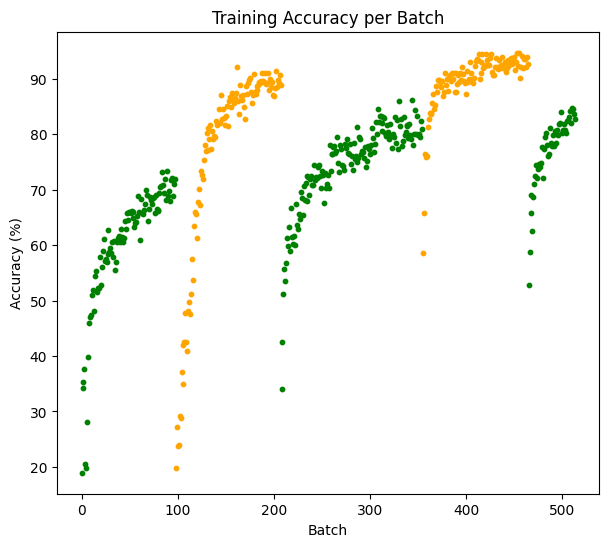

In [ ]:
plt.figure(figsize=(7, 6))
for i, acc in enumerate(all_accuracies):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/118, acc, color=colors[i], s=8)  # 's' controls the size of the scatter points
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

## 5) MNIST5 + FashionMNIST5

In [ ]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets
train_dataset1 = datasets.MNIST('./MNIST', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

# Prepare the FashionMNIST dataset with normalization
train_dataset2 = datasets.FashionMNIST('./FashionMNIST', train=True, download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.2860], std=[0.3530])
                                     ]))

# Prepare datasets
test_dataset1 = datasets.MNIST('./MNIST', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

# Prepare the FashionMNIST dataset with normalization
test_dataset2 = datasets.FashionMNIST('./FashionMNIST', train=False, download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.2860], std=[0.3530])
                                     ]))

# Separate datasets for each head
indices_head1 = [i for i, (_, target) in enumerate(train_dataset1) if target < 5]
indices_head2 = [i for i, (_, target) in enumerate(train_dataset2) if target >= 5]

indices_head1_test = [i for i, (_, target) in enumerate(test_dataset1) if target < 5]
indices_head2_test = [i for i, (_, target) in enumerate(test_dataset2) if target >= 5]


# The first dataset includes the classes for the first head, and the second dataset for the second head
dataset_head1 = Subset(train_dataset1, indices_head1)
dataset_head2 = Subset(train_dataset2, indices_head2)

dataset_head1_test = Subset(test_dataset1, indices_head1_test)
dataset_head2_test = Subset(test_dataset2, indices_head2_test)

bs = 512
loader_head1 = DataLoader(dataset_head1, batch_size=bs, shuffle=True)
loader_head2 = DataLoader(dataset_head2, batch_size=bs, shuffle=True)

val_bs = 512
loader_head1_test = DataLoader(dataset_head1_test, batch_size=val_bs, shuffle=True)
loader_head2_test = DataLoader(dataset_head2_test, batch_size=val_bs, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14162587.44it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209271.70it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3882641.01it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5384607.73it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [ ]:
# Define how many epochs to run for each head before switching
run_lengths = [3,6,10,15]
total_epochs = 30*2  # Total number of epochs to train

for run_length in run_lengths:
  print(f'***Running for run_length={run_length}***')
  all_losses = []
  all_accuracies = []
  all_accuracies_val1 = [] # Validation output for head 1
  all_accuracies_val2 = [] # Validation output for head 2
  batch_heads = []
  colors = []
  model = MultiHeadCNN_MNIST().to(device)
  #optimizer = Adam(model.parameters())
  optimizer_name = 'SGD'
  optimizer = SGD(model.parameters(),lr=0.002, momentum=0.0)
  experiment_name = f'mnist5_fashionmnist5/rl{run_length}_bs{bs}_epochs{total_epochs//2}_{optimizer_name}_lr{optimizer.param_groups[0]["lr"]}_momentum{optimizer.param_groups[0]["momentum"]}'
  if run_length == 0: # Reserve 0 for iid setting
    training_loop_iid(model, optimizer, run_length, total_epochs//2, experiment_name)
  else:
    training_loop(model, optimizer, run_length, total_epochs, experiment_name)

***Running for run_length=3***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 2, epoch 4...


Training Progress: 100%|██████████| 59/59 [00:12<00:00,  4.55it/s]


On head 2, epoch 5...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 6...


Training Progress: 100%|██████████| 59/59 [00:14<00:00,  4.16it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.48it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.51it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 1, epoch 19...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


On head 1, epoch 20...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.51it/s]


On head 1, epoch 21...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


On head 2, epoch 40...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 2, epoch 41...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


On head 2, epoch 42...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.36it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


On head 1, epoch 55...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 56...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 57...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


***Running for run_length=6***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.49it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


On head 2, epoch 7...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 8...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 2, epoch 9...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.51it/s]


On head 2, epoch 10...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 16...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.30it/s]


On head 1, epoch 17...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 18...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.34it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:14<00:00,  4.27it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


On head 2, epoch 43...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 44...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 45...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 51...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 52...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


On head 1, epoch 53...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 54...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.36it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


***Running for run_length=10***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.53it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


On head 2, epoch 11...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 12...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 2, epoch 13...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 14...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 2, epoch 15...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 1, epoch 21...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


On head 1, epoch 22...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 23...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 24...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.47it/s]


On head 1, epoch 25...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 26...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 27...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 28...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 1, epoch 29...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 30...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 2, epoch 31...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 32...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 2, epoch 33...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 34...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 35...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


On head 2, epoch 36...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 37...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 2, epoch 38...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 2, epoch 39...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


On head 2, epoch 40...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s]


On head 1, epoch 46...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 47...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 48...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 49...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 50...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


***Running for run_length=15***
On head 1, epoch 1...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 2...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 3...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 4...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 5...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 6...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 7...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


On head 1, epoch 8...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 9...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


On head 1, epoch 10...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 11...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.38it/s]


On head 1, epoch 12...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


On head 1, epoch 13...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


On head 1, epoch 14...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 15...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 2, epoch 16...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.36it/s]


On head 2, epoch 17...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


On head 2, epoch 18...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 19...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.27it/s]


On head 2, epoch 20...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


On head 2, epoch 21...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.29it/s]


On head 2, epoch 22...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 23...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 24...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 2, epoch 25...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.35it/s]


On head 2, epoch 26...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 27...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 28...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 29...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


On head 2, epoch 30...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 1, epoch 31...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s]


On head 1, epoch 32...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.35it/s]


On head 1, epoch 33...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 34...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.39it/s]


On head 1, epoch 35...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 36...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 37...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 38...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.46it/s]


On head 1, epoch 39...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.40it/s]


On head 1, epoch 40...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


On head 1, epoch 41...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.42it/s]


On head 1, epoch 42...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


On head 1, epoch 43...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]


On head 1, epoch 44...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.43it/s]


On head 1, epoch 45...


Training Progress: 100%|██████████| 60/60 [00:13<00:00,  4.44it/s]


On head 2, epoch 46...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.49it/s]


On head 2, epoch 47...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


On head 2, epoch 48...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.47it/s]


On head 2, epoch 49...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s]


On head 2, epoch 50...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


On head 2, epoch 51...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


On head 2, epoch 52...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


On head 2, epoch 53...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


On head 2, epoch 54...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


On head 2, epoch 55...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


On head 2, epoch 56...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


On head 2, epoch 57...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


On head 2, epoch 58...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


On head 2, epoch 59...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


On head 2, epoch 60...


Training Progress: 100%|██████████| 59/59 [00:13<00:00,  4.26it/s]


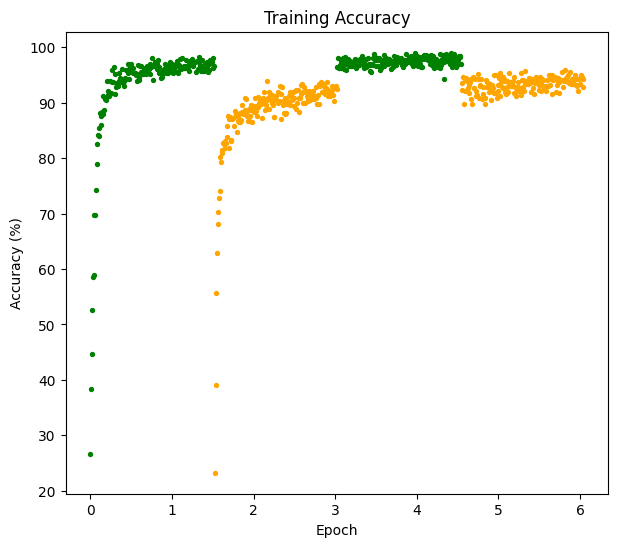

In [ ]:
plt.figure(figsize=(7, 6))
for i, acc in enumerate(all_accuracies):
    # Divide i by the number of batches in an epoch (task1 + task2)
    plt.scatter(i/118, acc, color=colors[i], s=8)  # 's' controls the size of the scatter points
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
data = {
    'all_losses': all_losses,
    'all_accuracies': all_accuracies,
    'batch_heads': batch_heads,
    'colors': colors
}

# Define the file path
file_path = drive_results_path + f'/mnist5_fashionmnist5_rl{run_length}_bs{bs}.json'

# Write the dictionary to a file as JSON
with open(file_path, 'w') as file:
    json.dump(data, file)

# Read the JSON file back into a dictionary
with open(file_path, 'r') as file:
    loaded_data = json.load(file)

# Access the data
#loaded_all_losses = loaded_data['all_losses']
#loaded_all_accuracies = loaded_data['all_accuracies']
#loaded_batch_heads = loaded_data['batch_heads']
#loaded_colors = loaded_data['colors']


# Extended Training in Interleaved and Blocked Settings

# EXTRA: Interleaving Three Tasks

## 6) CIFAR3 + CIFAR3 + CIFAR3

## 7) MNIST3 + MNIST3 + FashionMNIST3